# Linear regression 

In this exercise you will use linear regression to predict flat prices. One more time, training will be handled via gradient descent. Although, contratry to the first exercise, we will now:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a different loss function.

Let's start with getting the data.

In [73]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

--2021-03-18 15:31:46--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2021-03-18 15:31:46--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc760e3dda744f1795abee980149.dl.dropboxusercontent.com/cd/0/get/BK7mRF2H09l9AK9uiaqqghbu1SWESES0ijr4EbpxUjYi-ZKnVVuC6mpxcJeZcP-D2DsDPtJJ-Sf8llBa_1Wr35DNITFPUx2OfZ8oLWKSHyQCyOqvzIqxLdwpioAvHarz3_M3V9_QtnUQVytBnMwgtbQ-/file?dl=1# [following]
--2021-03-18 15:31:47--  https://uc760e3dda744f1795abee980149.dl.dropboxusercontent.com/cd/0/get/BK7mRF2H09l9AK9uiaqqghbu1SWESES0ijr4EbpxUjYi-ZKnVVuC6mpxcJeZcP-D2DsDPtJJ-Sf8llBa_1

In [74]:
!head mieszkania.csv mieszkania_test.csv

==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


In [75]:
import pandas as pd
train = pd.read_csv('mieszkania.csv')
test = pd.read_csv('mieszkania_test.csv')

total = pd.concat([train,test])

total = pd.get_dummies(total, prefix='dzielnica')

train = total[:len(train)]
test = total[len(train):]

Each row in the data represents a separate property. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a property's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny`). 

From now on, we should interfere only with `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

Our predictions should minimize the so-called mean squared logarithmic error:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's start with implementing the loss function.

In [76]:
import numpy as np

In [77]:
def msle(ys, ps):
    assert len(ys) == len(ps)
    return np.mean((np.log1p(ys)-np.log1p(ps))**2)

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [78]:
###################################################
# Compute msle for outputing the mean price #
###################################################
n=len(test)

mean_price_train = np.mean(train['cena'])
print(f'mean price {mean_price_train}')
print(f"msle for the same constant: {msle(ys=test['cena'], ps=np.full(n, fill_value=mean_price_train))}")

mean price 507919.49
msle for the same constant: 0.4284115392580848


Recall that outputing the mean minimzes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

In [79]:
#############################################
# TODO: Find this constant and compute msle #
#############################################
# \sum_{i=1}^n (log(1+yi) - log(1+c))^2 ---> min
# when log(1+c) = 1/n (log(1+y1)+...+log(1+yn))
# 1+c = np.exp(1/n (log(1+y1)+...+log(1+yn)) )
# c = np.exp(np.mean(np.log(1+train['cena']))) - 1
c = np.exp(np.mean(np.log(1+train['cena']))) - 1
print(f"msle for the same constant: {msle(ys=test['cena'], ps=np.full(n, fill_value=np.log(1+c)))}")

msle for the same constant: 108.92801987955298


Now, let's implement a standard linear regression model. 

In [80]:
def generate(train, test):
  train_y = train['cena'].to_numpy()
  test_y = test['cena'].to_numpy()
  n=len(test_y)

  train_x = train.drop('cena', axis = 1)
  test_x = test.drop('cena', axis = 1)
  
  mean, std = train_x.mean().to_numpy(), train_x.std().to_numpy()

  train_x, test_x = train_x.to_numpy(), test_x.to_numpy()

  train_x = (train_x - mean) / std
  train_x = np.hstack((np.ones_like(train_x), train_x)) # bias

  test_x = (test_x - mean) / std
  test_x = np.hstack((np.ones_like(test_x), test_x)) # bias
  return train_x, train_y, test_x, test_y, n

  
train_x, train_y, test_x, test_y, n = generate(train, test)

In [81]:
##########################################################
# TODO: Implement linear regression and compute its msle #
##########################################################
lr=0.001

def evaluate(ws, xs, ys):
    ps = np.dot(xs, ws)
    assert len(ys) == len(ps)
    return np.mean((ys - ps)**2)
    

def fit(x, y, steps, silence=False):
  W = np.random.normal(size=x.shape[1])
  for i in range(steps):
    # Loss(w0, w1, w2,..., wn) = (y - \sum w_ix_i)**2
    # pred = x1w1 + ... + xnwn
    preds = np.dot(x, W)
    delta = preds - y

    # Loss =  \sum (yt - (x1w1 + ... + xnwn))^2
    # dLoss/dw_i = 2*(w1x1 + ... +wnxn - y)*xi
    gradient = (2/n)*np.dot(x.T,  delta)
    W-=lr*gradient
    
    if not silence and i % 10_000 == 0:
      loss=evaluate(W, x, y)
      print('Iter: {:>3} Loss: {:8.8f}'.format(i, loss))
  return W



In [82]:
W=fit(train_x, train_y, 100000)
W_l=fit(train_x, np.log1p(train_y), 100000)

Iter:   0 Loss: 321882863231.82489014
Iter: 10000 Loss: 4158723828.79775095
Iter: 20000 Loss: 3910094950.74513721
Iter: 30000 Loss: 3874334349.90780926
Iter: 40000 Loss: 3869190065.38943768
Iter: 50000 Loss: 3868450042.41191387
Iter: 60000 Loss: 3868343587.56763554
Iter: 70000 Loss: 3868328273.67304945
Iter: 80000 Loss: 3868326070.71677113
Iter: 90000 Loss: 3868325753.81395388
Iter:   0 Loss: 161.67087959
Iter: 10000 Loss: 0.03060003
Iter: 20000 Loss: 0.03028495
Iter: 30000 Loss: 0.03025202
Iter: 40000 Loss: 0.03024729
Iter: 50000 Loss: 0.03024661
Iter: 60000 Loss: 0.03024651
Iter: 70000 Loss: 0.03024650
Iter: 80000 Loss: 0.03024649
Iter: 90000 Loss: 0.03024649


In [83]:
pred=test_x @ W
print(f'Score after regression = {msle(test_y, pred)}')
print(list(zip(pred[:10], test_y[:10])))

Score after regression = 0.18097954621205375
[(377531.007334084, 322227), (371324.0075870777, 295878), (363304.2403211501, 306530), (552899.7397500583, 553641), (961779.6817857951, 985348), (757216.1745966498, 695726), (1711.4214795689077, 99751), (814211.6758480521, 891261), (538791.6709010483, 536499), (637412.9729519296, 527093)]


Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint: 
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
</sup></sub></sup></sub></sup></sub>

In [84]:
pred=np.expm1(test_x @ W_l)
print(f'Score after regression = {msle(test_y, pred)}')
print(list(zip(pred[:10], test_y[:10])))


Score after regression = 0.03656926782760693
[(325336.8617246885, 322227), (319969.887647719, 295878), (296900.6432009463, 306530), (424576.0669180581, 553641), (1198613.7398975447, 985348), (801494.3340599345, 695726), (141144.0381914065, 99751), (860727.594437828, 891261), (447011.7082576086, 536499), (618669.6830994077, 527093)]


Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code. 

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

*Hint*: 
Is having a binary encoding for each district and multiplying it by area enough?


*Hint* 2: 
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).


In [85]:
###############################################
# TODO: Implement the feature engieering part #
###############################################

# m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny

cols = [x for x in train.columns if x != 'cena']

def mul_cols(df):
  a,b = df.shape
  ndf = np.zeros(shape=(a,int(b*(b+1)/2)))
  k=0
  for i in range(b):
    for j in range(i, b):
      ndf[:, k] = df[:, i]*df[:, j]
      k+=1
  return ndf

train_x_new = mul_cols(train_x)
test_x_new = mul_cols(test_x)

In [86]:
W_l=fit(train_x_new, np.log1p(train_y), 100000)
pred=np.expm1(test_x_new @ W_l)
print(f'Score after regression = {msle(test_y, pred)}')
print(list(zip(pred[:10], test_y[:10])))


Iter:   0 Loss: 287.61338196
Iter: 10000 Loss: 0.12638897
Iter: 20000 Loss: 0.02202092
Iter: 30000 Loss: 0.00948516
Iter: 40000 Loss: 0.00761402
Iter: 50000 Loss: 0.00719285
Iter: 60000 Loss: 0.00701272
Iter: 70000 Loss: 0.00689394
Iter: 80000 Loss: 0.00680336
Iter: 90000 Loss: 0.00673135
Score after regression = 0.019685592942136582
[(430064.7569111954, 322227), (339197.92737425247, 295878), (283126.15822682343, 306530), (515873.8580421483, 553641), (951218.3968472448, 985348), (662628.395591283, 695726), (117612.03015041549, 99751), (871016.0206106856, 891261), (536105.5728671807, 536499), (510508.0770674603, 527093)]


# Validation and cross-validation 

In this exercise you will implement a validation pipeline. 

At the end of Exercise 2, you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, not only should you be able to anticipate the test time performance, but also have a method to compare different models.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise 2.

In [87]:
#######################################################
# TODO: Implement the basic validation method,        # 
# compare MSLE on training, validation, and test sets #
#######################################################

def random_split(x, y, valid):
  assert(len(x) == len(y))
  assert(valid <= 1 and valid >= 0)
  idxs = np.random.permutation(len(x))
  n_train = int(len(x)-len(x)*valid)
  print(f'{len(x)-n_train} valid examples')
  x = x[idxs]
  y = y[idxs]

  x_train, x_valid = x[:n_train], x[n_train:]
  y_train, y_valid = y[:n_train], y[n_train:]

  return x_train, y_train, x_valid, y_valid

In [88]:
val_losses = []
test_losses = []
for _ in range(15):
  train_x_split, train_y_split, valid_x_split, valid_y_split = random_split(train_x, train_y, 0.2)
  W_l=fit(train_x_split, np.log1p(train_y_split), 100000, silence=True)
  val_losses.append(msle(valid_y_split, np.expm1(valid_x_split @ W_l)))
  test_losses.append(msle(test_y, np.expm1(test_x @ W_l)))
print(test_losses)

40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
40 valid examples
[0.03810245189473322, 0.03594949392287419, 0.038249602983213914, 0.03681520685916844, 0.036709047325118725, 0.04010505609575225, 0.038348059872545075, 0.03721855712765142, 0.036129761993311, 0.03716279052150649, 0.037721601033631064, 0.03608313662446154, 0.037006092827457815, 0.03546029678440104, 0.03634692987965827]


(array([0., 2., 2., 7., 3., 1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 <a list of 6 Patch objects>)

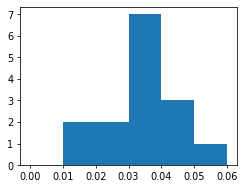

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=70)
plt.hist(val_losses, bins=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])

To make the random split validation reliable, a huge chunk of training data may be needed. To get over this problem, one may apply cross-validaiton.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)


Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [99]:
####################################
# TODO: Implement cross-validation # 
####################################

def cross_validation(x, y, k, fit_fn, loss_fn):
  idxs = np.random.permutation(len(x))
  x = x[idxs]
  y = y[idxs]
  

  n_valid = int(len(x)/k)
  rounds = []
  for idx in range(k):
    bucket_x = x[n_valid*idx:n_valid*(idx+1)]
    bucket_y = y[n_valid*idx:n_valid*(idx+1)]
    train_x = np.concatenate([x[:n_valid*idx], x[n_valid*(idx+1):]])
    train_y = np.concatenate([y[:n_valid*idx], y[n_valid*(idx+1):]])

    W_l=fit_fn(train_x, np.log1p(train_y), 100000, silence=True)
    rounds.append(loss_fn(bucket_y, np.expm1(bucket_x @ W_l)))

  final_accuracy = np.mean(rounds)
  print(f'rounds: {rounds}')
  return final_accuracy

In [101]:
print(cross_validation(train_x, train_y, 10, fit, msle))


rounds: [0.02891127464418076, 0.03671022349081271, 0.04153067900494091, 0.026542398855219855, 0.02142732210271515, 0.016815135718690016, 0.02287070903777057, 0.02508910604920784, 0.0798634135263068, 0.030998524718669884]
0.033075878714851445


Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

9


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

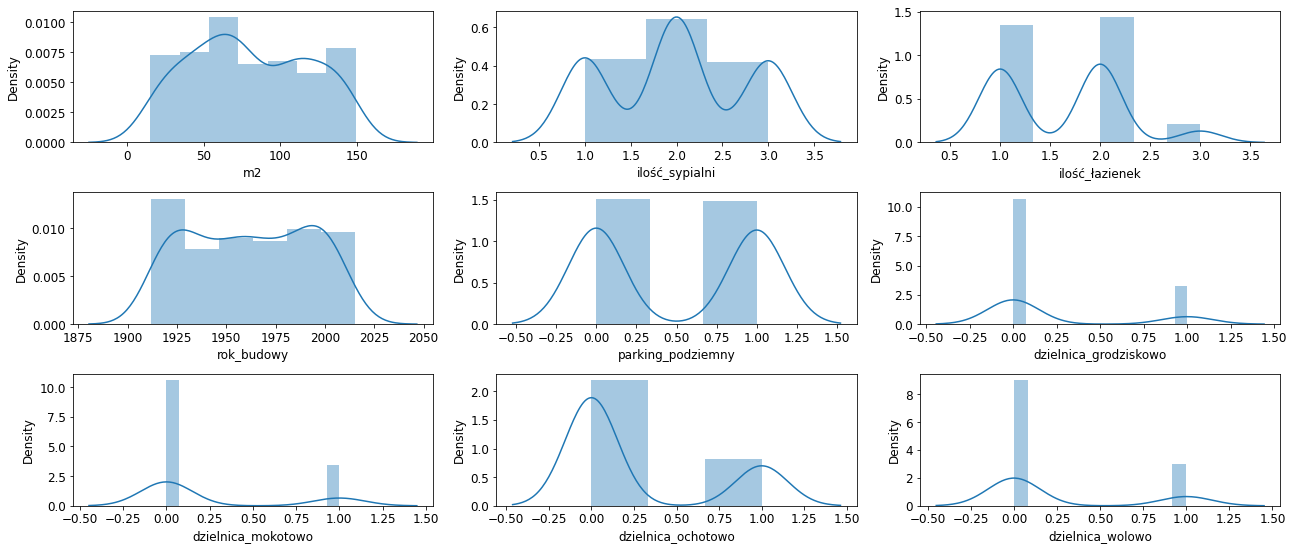

In [104]:
##############################
# TODO: Investigate the data #
##############################
import seaborn as sns

# m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena

plt.rcParams.update({'font.size': 12})
numerical_features = train.select_dtypes(exclude=['object']).drop(['cena'], axis=1).copy()
fig = plt.figure(figsize=(18,30))
print(len(numerical_features.columns))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(12,3,i+1)
    sns.distplot(numerical_features.iloc[:,i].dropna())
    plt.xlabel(numerical_features.columns[i])
plt.tight_layout()
plt.show()

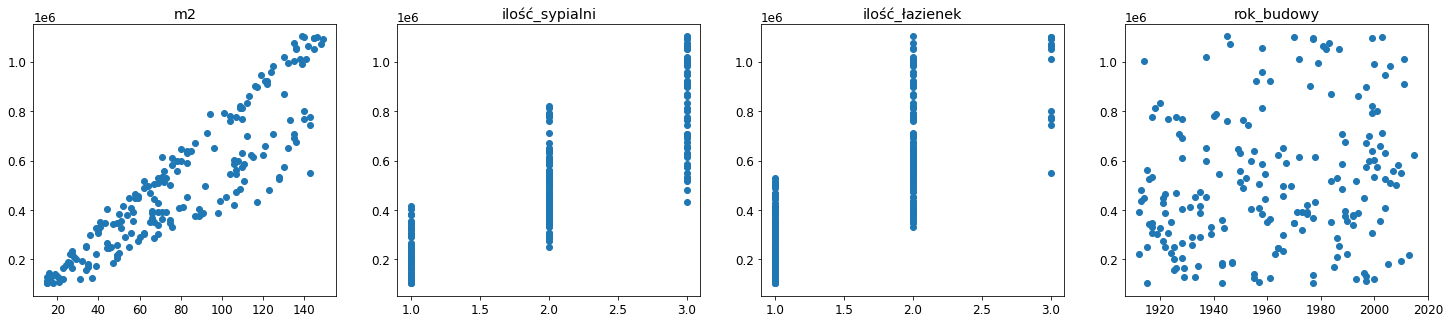

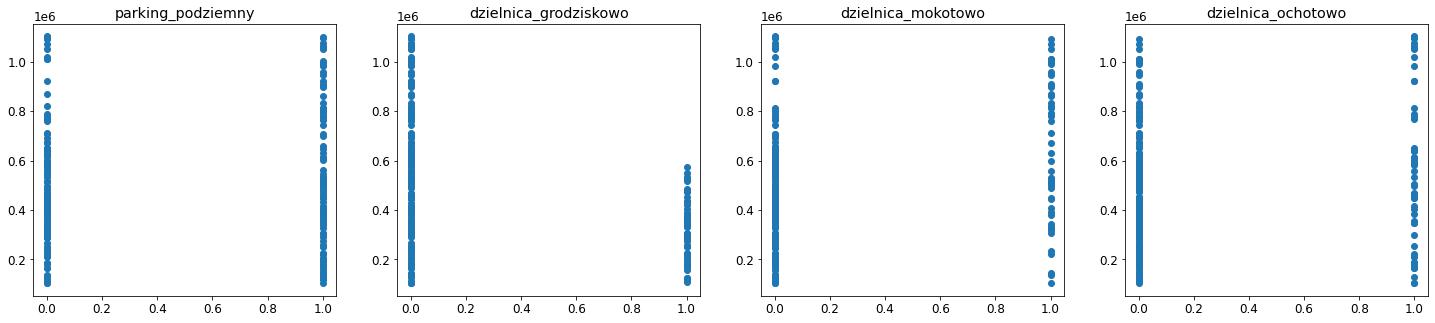

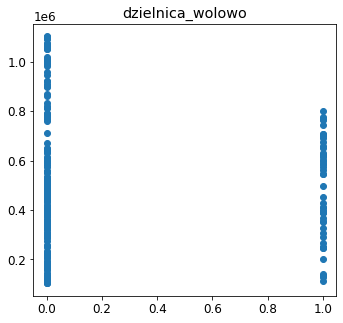

In [107]:
figures_per_time = 4
count = 0 
y = train['cena']
for var in numerical_features:
    x = train[var]
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,4)+1)
    plt.scatter(x, y);
    plt.title(var)
    count+=1

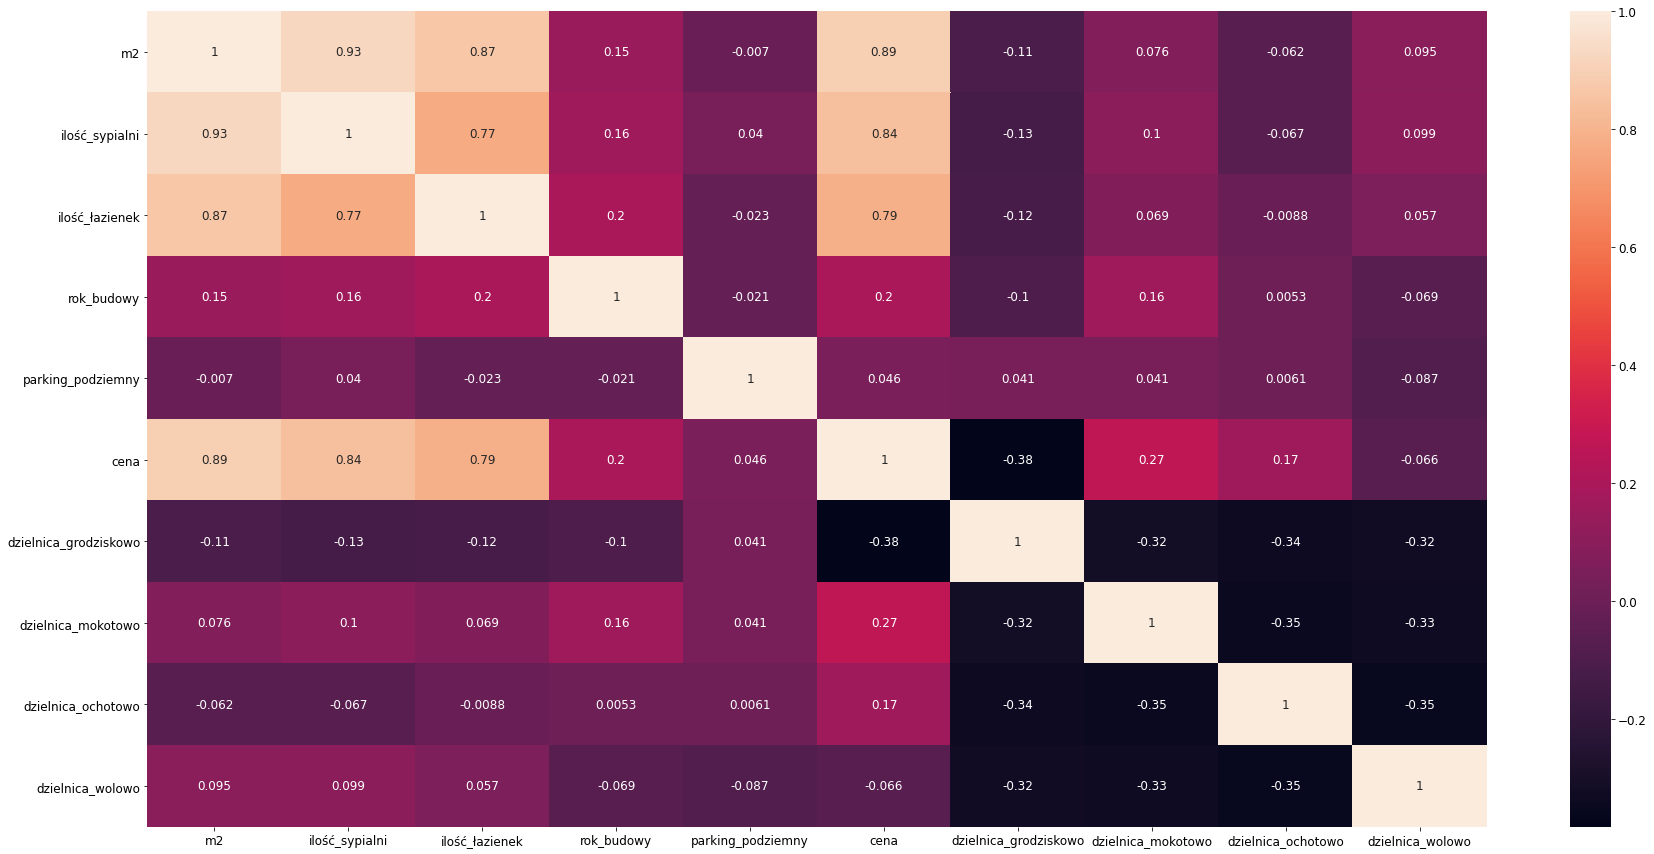

In [108]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr(), annot=True)

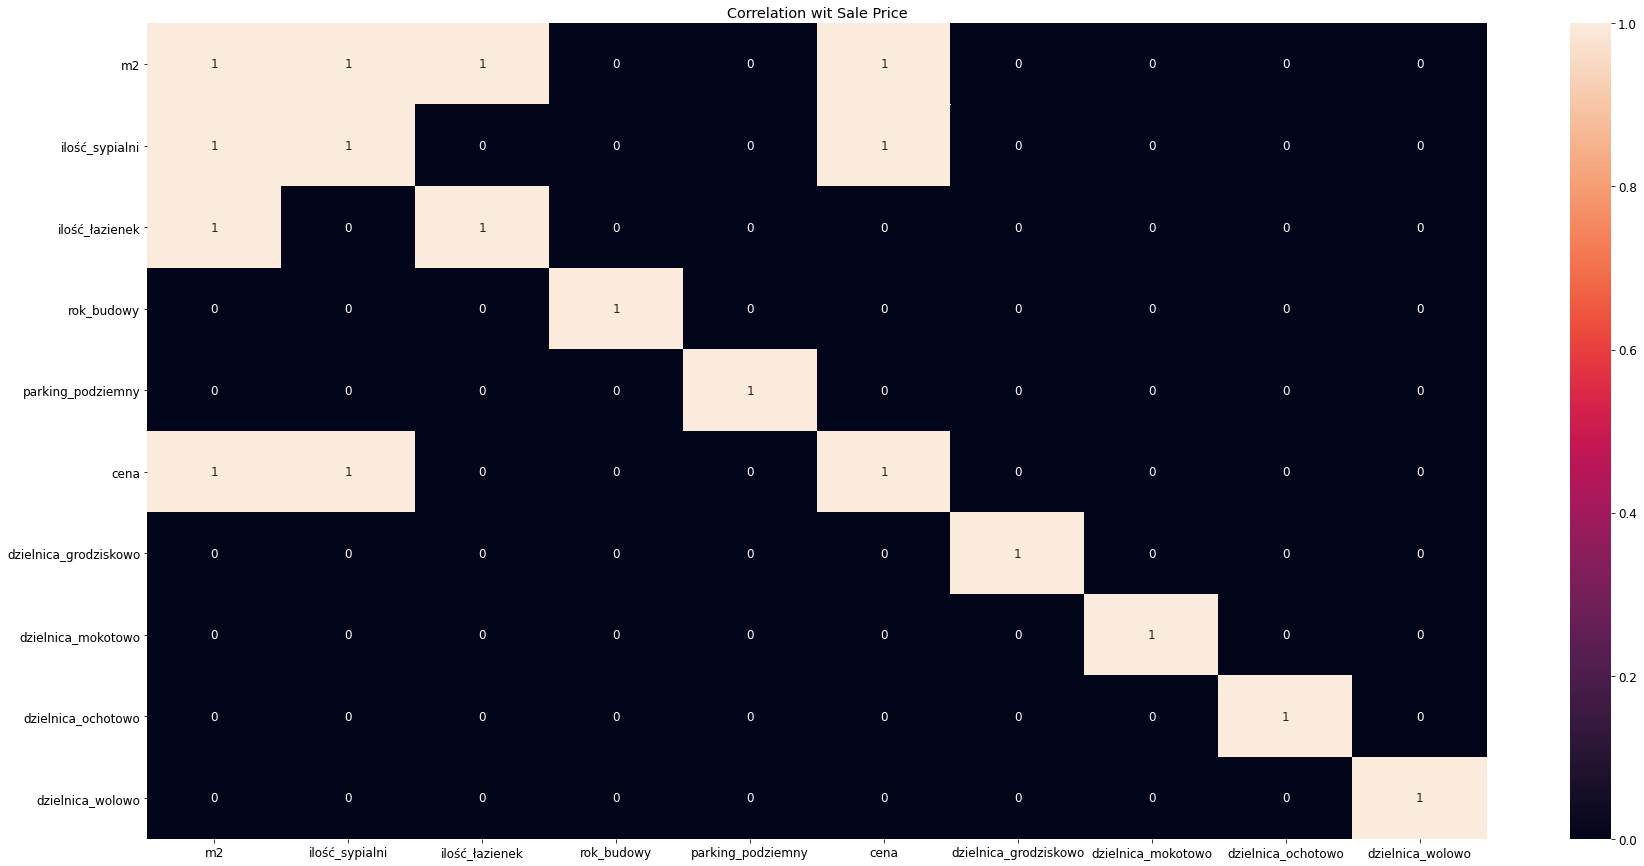

In [109]:
correlation_num = train.select_dtypes(exclude='object').corr()
plt.figure(figsize=(30,15))
plt.title('Correlation wit Sale Price')
sns.heatmap(data=correlation_num>0.80, annot=True)